In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from datasets import load_dataset
from src.attention_rollout import AttentionRollout
from src.gradient_rollout import AttentionGradRollout
from src.influence import Influence
from src.raw_attention import RawAttention
from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm

import seaborn as sns
import numpy as np
import pandas as pd
import wordcloud
from src.text_utils import remove_stopwords, remove_punctuation, get_word_frequencies, lemmatize_text
from copy import deepcopy
from IPython.display import clear_output
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])
from src.perturbation import perturb_text

[nltk_data] Downloading package punkt to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

In [3]:
device = 'cuda'

### Ag News

In [4]:
train_dataset = load_dataset("SetFit/ag_news", cache_dir='/Data', split = 'train')\
    .train_test_split(test_size=1000, train_size=2000, seed=1)

test_dataset = load_dataset("SetFit/ag_news", cache_dir='/Data', split = 'test')

In [5]:
n_classes = len(np.bincount(train_dataset['train']['label']))

In [6]:
label_names = {
    0 : "World",
    1 : "Sports",
    2 : "Business",
    3 : "Sci/Tech"
}

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(
    "peulsilva/bert-ag_news", 
    attn_implementation = 'eager', 
    num_labels = n_classes,
    cache_dir = '/Data'
)\
    .to(device)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


In [8]:
batch_size = 1
train_dataloader = DataLoader(train_dataset['train'], batch_size=batch_size)
val_dataloader = DataLoader(train_dataset['test'], batch_size=batch_size)

## Raw attention scores

In [9]:
metric = RawAttention(model, attention_layer_name='attention')

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(val_dataloader):
        tokens = tokenizer(
            row['text'], 
            return_tensors='pt',
            padding = 'longest'
        )

        out, attn_matrix = metric(**tokens.to(device), layer_idx=0)

        new_input = perturb_text(tokens, attn_matrix.squeeze(), k, tokenizer, most_important=False)
        # print(new_input['input_ids'].shape)
        
        with torch.no_grad():
            out = model(**new_input.to(device))

        y_pred = out.logits.argmax().to('cpu').unsqueeze(dim= 0 )
        y_true = row['label'].to('cpu')


        y_pred_test = torch.concat([y_pred_test, y_pred])
        y_true_test = torch.concat([y_true_test, y_true])

        acc = (y_true_test == y_pred_test).sum()/len(val_dataloader)

        accs[k] = acc

    print(f"Removed {k} best tokens. Accuracy = {acc}")

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:13<00:00, 73.84it/s]


Removed 0.0 best tokens. Accuracy = 0.9039999842643738


100%|██████████| 1000/1000 [00:14<00:00, 70.11it/s]


Removed 0.1 best tokens. Accuracy = 0.8989999890327454


100%|██████████| 1000/1000 [00:14<00:00, 70.41it/s]


Removed 0.2 best tokens. Accuracy = 0.8799999952316284


100%|██████████| 1000/1000 [00:14<00:00, 70.66it/s]


Removed 0.30000000000000004 best tokens. Accuracy = 0.8500000238418579


100%|██████████| 1000/1000 [00:14<00:00, 70.76it/s]


Removed 0.4 best tokens. Accuracy = 0.8230000138282776


100%|██████████| 1000/1000 [00:14<00:00, 70.81it/s]


Removed 0.5 best tokens. Accuracy = 0.7390000224113464


100%|██████████| 1000/1000 [00:14<00:00, 71.07it/s]


Removed 0.6000000000000001 best tokens. Accuracy = 0.6790000200271606


100%|██████████| 1000/1000 [00:14<00:00, 71.36it/s]


Removed 0.7000000000000001 best tokens. Accuracy = 0.5630000233650208


100%|██████████| 1000/1000 [00:13<00:00, 71.50it/s]


Removed 0.8 best tokens. Accuracy = 0.414000004529953


100%|██████████| 1000/1000 [00:13<00:00, 71.49it/s]

Removed 0.9 best tokens. Accuracy = 0.27000001072883606


In [12]:
pd.Series(accs).apply(lambda x: x.item())\
    .to_pickle("data/results/raw_attention0_perturbation_negative.pkl")

# Attention Rollout

In [9]:
metric = AttentionRollout(model, attention_layer_name='attention')

In [10]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(val_dataloader):
        tokens = tokenizer(
            row['text'], 
            return_tensors='pt',
            padding = 'longest'
        )

        out, attn_matrix = metric(**tokens.to(device), output_attentions = True)

        new_input = perturb_text(tokens, attn_matrix.squeeze(), k, tokenizer, most_important=False)
        # print(new_input['input_ids'].shape)
        
        with torch.no_grad():
            out = model(**new_input.to(device))

        y_pred = out.logits.argmax().to('cpu').unsqueeze(dim= 0 )
        y_true = row['label'].to('cpu')


        y_pred_test = torch.concat([y_pred_test, y_pred])
        y_true_test = torch.concat([y_true_test, y_true])

        acc = (y_true_test == y_pred_test).sum()/len(val_dataloader)

        accs[k] = acc

    print(f"Removed {k} worst tokens. Accuracy = {acc}")

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:17<00:00, 55.60it/s]


Removed 0.0 best tokens. Accuracy = 0.9039999842643738


100%|██████████| 1000/1000 [00:19<00:00, 52.59it/s]


Removed 0.1 best tokens. Accuracy = 0.9089999794960022


100%|██████████| 1000/1000 [00:19<00:00, 51.67it/s]


Removed 0.2 best tokens. Accuracy = 0.9079999923706055


100%|██████████| 1000/1000 [00:19<00:00, 51.92it/s]


Removed 0.30000000000000004 best tokens. Accuracy = 0.9089999794960022


100%|██████████| 1000/1000 [00:19<00:00, 51.95it/s]


Removed 0.4 best tokens. Accuracy = 0.9089999794960022


100%|██████████| 1000/1000 [00:19<00:00, 52.44it/s]


Removed 0.5 best tokens. Accuracy = 0.8999999761581421


100%|██████████| 1000/1000 [00:19<00:00, 52.49it/s]


Removed 0.6000000000000001 best tokens. Accuracy = 0.8960000276565552


100%|██████████| 1000/1000 [00:19<00:00, 52.53it/s]


Removed 0.7000000000000001 best tokens. Accuracy = 0.8840000033378601


100%|██████████| 1000/1000 [00:19<00:00, 52.41it/s]


Removed 0.8 best tokens. Accuracy = 0.8529999852180481


100%|██████████| 1000/1000 [00:19<00:00, 52.57it/s]

Removed 0.9 best tokens. Accuracy = 0.6539999842643738


In [12]:
pd.Series(accs).apply(lambda x: x.item())\
    .to_pickle("data/results/attn_rollout_perturbation_negative.pkl")

## Gradient attention rollout

In [13]:
metric = AttentionGradRollout(model, attention_layer_name='attention.self.dropout')

In [14]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(val_dataloader):
        tokens = tokenizer(
            row['text'], 
            return_tensors='pt',
            padding = 'longest'
        )

        tokens['labels'] = row['label']

        out, attn_matrix = metric(**tokens.to(device), output_attentions = True)

        new_input = perturb_text(tokens, attn_matrix.squeeze(), k, tokenizer, most_important = False)
        # print(new_input['input_ids'].shape)
        
        with torch.no_grad():
            out = model(**new_input.to(device))

        y_pred = out.logits.argmax().to('cpu').unsqueeze(dim= 0 )
        y_true = row['label'].to('cpu')


        y_pred_test = torch.concat([y_pred_test, y_pred])
        y_true_test = torch.concat([y_true_test, y_true])

        acc = (y_true_test == y_pred_test).sum()/len(val_dataloader)

        accs[k] = acc

    print(f"Removed {k} worst tokens. Accuracy = {acc}")

  0%|          | 0/1000 [00:00<?, ?it/s]

/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
100%|██████████| 1000/1000 [00:31<00:00, 31.52it/s]


Removed 0.0 worst tokens. Accuracy = 0.9039999842643738


100%|██████████| 1000/1000 [00:32<00:00, 30.72it/s]


Removed 0.1 worst tokens. Accuracy = 0.9110000133514404


100%|██████████| 1000/1000 [00:32<00:00, 30.83it/s]


Removed 0.2 worst tokens. Accuracy = 0.9169999957084656


100%|██████████| 1000/1000 [00:32<00:00, 31.03it/s]


Removed 0.30000000000000004 worst tokens. Accuracy = 0.9129999876022339


100%|██████████| 1000/1000 [00:32<00:00, 30.93it/s]


Removed 0.4 worst tokens. Accuracy = 0.9190000295639038


100%|██████████| 1000/1000 [00:32<00:00, 30.49it/s]


Removed 0.5 worst tokens. Accuracy = 0.9110000133514404


100%|██████████| 1000/1000 [00:32<00:00, 31.08it/s]


Removed 0.6000000000000001 worst tokens. Accuracy = 0.9049999713897705


100%|██████████| 1000/1000 [00:32<00:00, 31.07it/s]


Removed 0.7000000000000001 worst tokens. Accuracy = 0.8999999761581421


100%|██████████| 1000/1000 [00:32<00:00, 31.07it/s]


Removed 0.8 worst tokens. Accuracy = 0.8730000257492065


100%|██████████| 1000/1000 [00:32<00:00, 30.93it/s]

Removed 0.9 worst tokens. Accuracy = 0.781000018119812


In [15]:
pd.Series(accs).apply(lambda x: x.item())\
    .to_pickle("data/results/grad_rollout_perturbation_negative.pkl")

## Influence 

In [16]:
metric = Influence(model, discard_ratio=0.9)

In [17]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(val_dataloader):
        tokens = tokenizer(
            row['text'], 
            return_tensors='pt',
            padding = 'longest'
        )

        tokens['labels'] = row['label']

        attn_matrix = metric(**tokens.to(device))

        new_input = perturb_text(tokens, attn_matrix, k, tokenizer, most_important = False)
        # print(new_input['input_ids'].shape)
        
        with torch.no_grad():
            out = model(**new_input.to(device))

        y_pred = out.logits.argmax().to('cpu').unsqueeze(dim= 0 )
        y_true = row['label'].to('cpu')


        y_pred_test = torch.concat([y_pred_test, y_pred])
        y_true_test = torch.concat([y_true_test, y_true])

        acc = (y_true_test == y_pred_test).sum()/len(val_dataloader)

        accs[k] = acc

    print(f"Removed {k} worst tokens. Accuracy = {acc}")

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:18<00:00, 52.86it/s]


Removed 0.0 worst tokens. Accuracy = 0.9039999842643738


100%|██████████| 1000/1000 [00:19<00:00, 50.27it/s]


Removed 0.1 worst tokens. Accuracy = 0.9089999794960022


100%|██████████| 1000/1000 [00:19<00:00, 50.87it/s]


Removed 0.2 worst tokens. Accuracy = 0.9110000133514404


100%|██████████| 1000/1000 [00:19<00:00, 51.02it/s]


Removed 0.30000000000000004 worst tokens. Accuracy = 0.9079999923706055


100%|██████████| 1000/1000 [00:19<00:00, 50.63it/s]


Removed 0.4 worst tokens. Accuracy = 0.9039999842643738


100%|██████████| 1000/1000 [00:20<00:00, 49.29it/s]


Removed 0.5 worst tokens. Accuracy = 0.9010000228881836


100%|██████████| 1000/1000 [00:19<00:00, 50.50it/s]


Removed 0.6000000000000001 worst tokens. Accuracy = 0.9010000228881836


100%|██████████| 1000/1000 [00:19<00:00, 51.71it/s]


Removed 0.7000000000000001 worst tokens. Accuracy = 0.8830000162124634


100%|██████████| 1000/1000 [00:19<00:00, 51.45it/s]


Removed 0.8 worst tokens. Accuracy = 0.8610000014305115


100%|██████████| 1000/1000 [00:19<00:00, 51.49it/s]

Removed 0.9 worst tokens. Accuracy = 0.7279999852180481


In [18]:
pd.Series(accs).apply(lambda x: x.item())\
    .to_pickle("data/results/influence_perturbation_negative.pkl")

## Final plot

raw_attention0 - AUC = 0.6434000089764595
attn_rollout - AUC = 0.7946999907493592
influence - AUC = 0.7994000017642975
grad_rollout - AUC = 0.8091500014066696


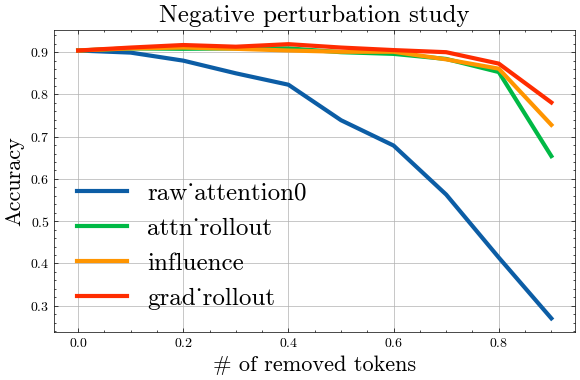

In [14]:
metrics = ['raw_attention0', 'attn_rollout','influence', 'grad_rollout', ]

plt.figure(figsize=(6,4))
for metric in metrics:
    x = pd.read_pickle(f"data/results/{metric}_perturbation_negative.pkl")
    auc = np.trapz(x.values, x.index)

    print(f"{metric} - AUC = {auc}")

    plt.plot(x, label = metric, linewidth = 3)

plt.grid()
plt.title("Negative perturbation study", fontsize = 18)
plt.ylabel("Accuracy", fontsize = 16)
plt.xlabel("# of removed tokens", fontsize = 16)
plt.legend(fontsize = 18)
plt.tight_layout()